In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import mysql.connector
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [7]:
## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1, dropnan=True, nskip = 0):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    if n_in + n_out == 0:
        return
    # skipped sequences (t + nskip, ... t + n)
    if nskip != 0:
        for j in range(n_vars):
            for i in np.arange(0, n_out, nskip):
                cols.append(df.iloc[:,j].shift(-i))
                names += [('{}{}(t+{})'.format(df.columns[0], j+1, i))]
    # regular sequences
    else:
        # input sequence (t-n, ... t-1)
        for j in range(n_vars):
            for i in range(n_in, 0, -1):
                cols.append(df.iloc[:,j].shift(i))
                names.append('{}{}(t-{})'.format(df.columns[0], j+1, i))

        # forecast sequence (t+1, ... t+n)
        for j in range(n_vars):
            for i in range(0, n_out):
                cols.append(df.iloc[:,j].shift(-i))
                names += [('{}{}(t+{})'.format(df.columns[0], j+1, i))]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}".format(name), row, True) 
        i += 1
    return plot_df

def get_eval(y, yhat):
    print("MSE: {}".format(mean_squared_error(y,yhat)))
    print("MAE: {}".format(mean_absolute_error(y,yhat)))
    print("r2_score: {}".format(r2_score(y,yhat, multioutput = "variance_weighted")))
    
## feature/ target construction fucntion with lag variable
def feature_target_construct(df, load_lag, target_ahead, temp_ahead, tskip = 0, wd_on = False):
    tempcols = ['temparature1','temparature2','temparature3','temparature4']
    load = df['TotalLoad']
    f_temp = pd.DataFrame()
    
    ## temp ahead series
    for col in tempcols:
        if(tskip != 0):
            temp = lag_ahead_series(df[col], 
                                 n_in = 0,
                                 n_out = temp_ahead,
                                 n_vars = 1,
                                 dropnan = True,
                                 nskip= tskip)
        else:
             temp = lag_ahead_series(df[col], 
                                 n_in = 0,
                                 n_out = temp_ahead,
                                 n_vars = 1,
                                 dropnan = True)
        f_temp = pd.concat([f_temp, temp], axis = 1)            
        
    ## load lag series
    f_load = lag_ahead_series(load,
                          n_in = load_lag,
                          n_out = 0,
                          n_vars = 1,
                          dropnan = True)
    # when f_temp exist
    if f_temp.shape[1] > 0:
        f_load, f_temp = f_load.align(f_temp, 'inner', axis = 0)
        f = pd.concat([f_temp, f_load], axis = 1)
    # when no f_temp
    else:
        f = f_load
        
    ## weekday on
    if wd_on:
        # weekday one hot encoding
        weekday = pd.get_dummies(df.iloc[:,-1])
        # alignment
        weekday , f = weekday.align(f, 'inner', axis = 0)
        f = pd.concat([weekday, f], axis = 1)
        
    ## number of LCLid on                  
    if('LCLid' in df.columns):
        nlclid = df['LCLid']
        # alignment
        nlclid, f = nlclid.align(f, 'inner', axis = 0)       
        f = pd.concat([f, nlclid], axis = 1)
        
        
    ## target part
    t = lag_ahead_series(load,
                          n_in = 0,
                          n_out = target_ahead,
                          n_vars = 1,
                          dropnan = True)
    # alignment of feature and target
    f, t = f.align(t, 'inner', axis = 0)
    
    return f, t


In [4]:
train = pd.read_csv("../data/train_elia.csv", index_col= 'time')
test = pd.read_csv("../data/test_elia.csv", index_col= 'time')

In [63]:
ftrain, ttrain = feature_target_construct(train, 96, 96, 96, 2, wd_on = True)
ftest, ttest = feature_target_construct(test, 96, 96, 96, 2, wd_on = True)

In [70]:
sm_ftrain = ftrain.iloc[-100:,:]
sm_ttrain = ttrain.iloc[-100:,:]

### TPOT: one day ahead, 15 mins

In [71]:
from tpot import TPOTRegressor
from tpot_grad import mul_reg_config_dict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
#import mul_config as mc

tpot_reg = TPOTRegressor(generations=10, 
                         population_size=40,
                         offspring_size=None, 
                         mutation_rate=0.9,
                         crossover_rate=0.1,
                         scoring='neg_mean_squared_error',
                         cv=TimeSeriesSplit(n_splits = 5),
                         subsample=1,
                         n_jobs=4,
                         max_time_mins=60, 
                         max_eval_time_mins=20,
                         random_state=123, 
                         config_dict=mul_reg_config_dict,
                         template=None,
                         warm_start=False,
                         memory=None,
                         use_dask=False,
                         periodic_checkpoint_folder=None,
                         early_stop=None,
                         verbosity=2,
                         disable_update_check=False)

tpot_reg.fit(sm_ftrain, sm_ttrain.iloc[:,0])


Generation 1 - Current best internal CV score: -295212.3148632527
Generation 2 - Current best internal CV score: -295154.4663843682
Generation 3 - Current best internal CV score: -276324.4582726318

66.97 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: HistGradientBoostingRegressor(input_matrix, l2_regularization=1.0, learning_rate=1.0, loss=least_squares, max_bins=255, max_depth=7, min_samples_leaf=6, validation_fraction=0.1)


TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

In [72]:
tpot_reg.fitted_pipeline_[0]

HistGradientBoostingRegressor(l2_regularization=1.0, learning_rate=1.0,
                              loss='least_squares', max_bins=255, max_depth=7,
                              max_iter=100, max_leaf_nodes=31,
                              min_samples_leaf=6, n_iter_no_change=None,
                              random_state=123, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)

In [41]:
from sklearn.feature_selection import SelectFromModel
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import ExtraTreesRegressor
sfm = SelectFromModel(estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                              criterion='mse', max_depth=None,
                                              max_features=0.7000000000000001,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=0.1)
tftrain = sfm.fit_transform(ftrain, ttrain.iloc[:,0])




In [74]:
hgb = HistGradientBoostingRegressor(l2_regularization=1.0, learning_rate=1.0,
                              loss='least_squares', max_bins=255, max_depth=7,
                              max_iter=100, max_leaf_nodes=31,
                              min_samples_leaf=6, n_iter_no_change=None,
                              random_state=123, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)
mhgb = RegressorChain(hgb)
mhgb.fit(sm_ftrain, sm_ttrain)

RegressorChain(base_estimator=HistGradientBoostingRegressor(l2_regularization=1.0,
                                                            learning_rate=1.0,
                                                            loss='least_squares',
                                                            max_bins=255,
                                                            max_depth=7,
                                                            max_iter=100,
                                                            max_leaf_nodes=31,
                                                            min_samples_leaf=6,
                                                            n_iter_no_change=None,
                                                            random_state=123,
                                                            scoring=None,
                                                            tol=1e-07,
                                                            validation

In [75]:
yhat = mhgb.predict(ftest.iloc[:100,:])

### Result Evaluation

In [77]:
get_eval(ttest.iloc[:100,:].to_numpy(), yhat)

MSE: 2355310.281322463
MAE: 1276.8015990961
r2_score: -0.970865342873094


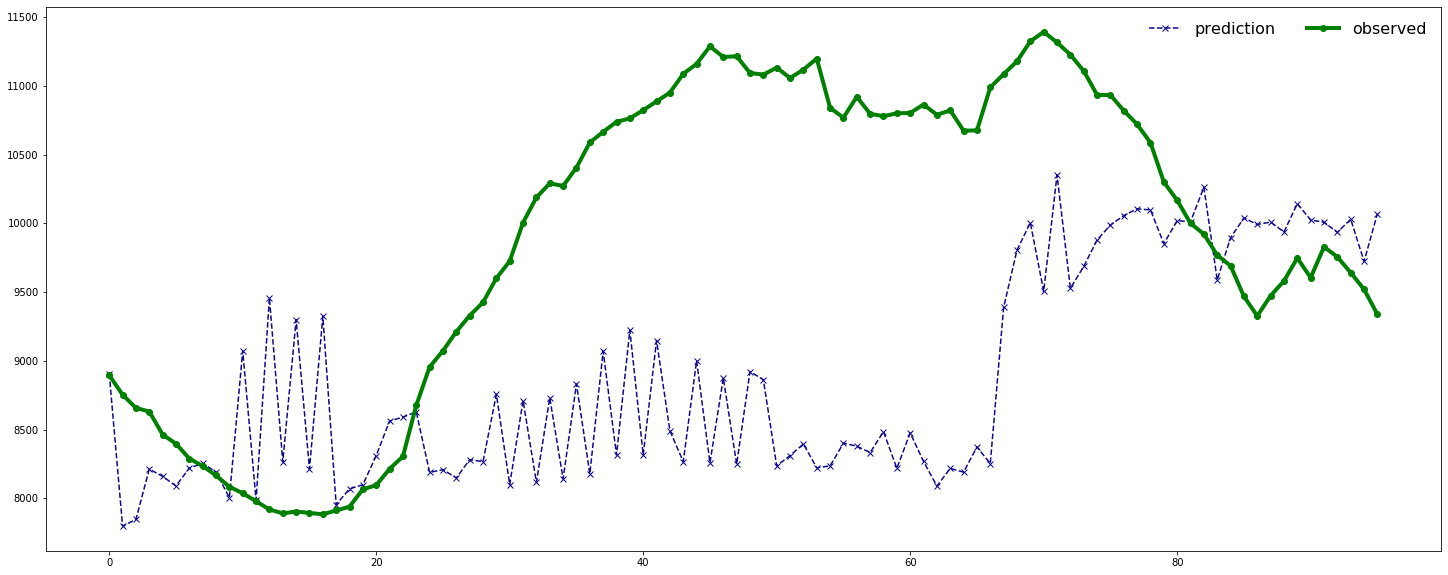

In [78]:
## assignment
real = ttest.to_numpy()
guess = yhat

real = real[1:2,:]
guess = guess[1:2,:]
rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--x',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

### TPOT: 24 hour ahead, half-hourly

In [7]:
from tpot import TPOTRegressor
from tpot_mulr import mul_reg_config_dict
from sklearn.model_selection import train_test_split
#import mul_config as mc

train_X, val_X, train_y, val_y = train_test_split(ahead_w, ahead_e, train_size = 0.05, test_size = 0.95, random_state = 123)

tpot_reg = TPOTRegressor(generations=30, 
                         population_size=60, 
                         n_jobs=4, 
                         verbosity=2, 
                         random_state=123,
                         subsample= 0.8,
                         config_dict=mul_reg_config_dict)
tpot_reg.fit(train_X , train_y)


Generation 1 - Current best internal CV score: -0.002535817417579815
Generation 2 - Current best internal CV score: -0.002530690697956506
Generation 3 - Current best internal CV score: -0.002530690697956506
Generation 4 - Current best internal CV score: -0.002510051020902841
Generation 5 - Current best internal CV score: -0.002510051020902841
Generation 6 - Current best internal CV score: -0.002510051020902841
Generation 7 - Current best internal CV score: -0.002491375270707632
Generation 8 - Current best internal CV score: -0.0024314059283892667
Generation 9 - Current best internal CV score: -0.0023766470404857337
Generation 10 - Current best internal CV score: -0.0023766470404857337
Generation 11 - Current best internal CV score: -0.0023766470404857337
Generation 12 - Current best internal CV score: -0.0023766470404857337
Generation 13 - Current best internal CV score: -0.002355760607122987
Generation 14 - Current best internal CV score: -0.002355760607122987
Generation 15 - Current 

TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

In [8]:
yhat = tpot_reg.predict(test_X)
mean_squared_error(test_y, yhat)
mean_absolute_error(test_y, yhat)
r2_score(test_y, yhat)

0.8708304000147385

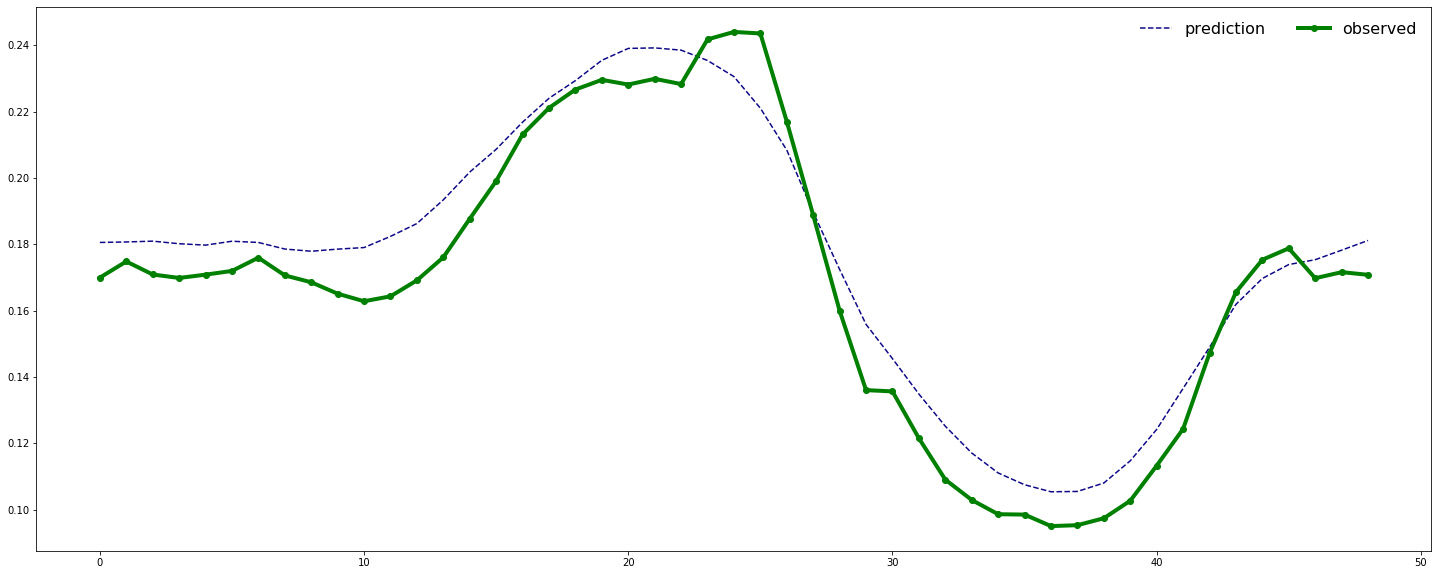

In [9]:
## assignment
real = test_y.to_numpy()
guess = yhat
real = real[50:51,:49]
guess = guess[50:51,:49]
rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()